In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("diabetic_data_initial.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [4]:
df.describe(include='object')

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,6,3,10,10,18,73,717,749,790,4,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),?,?,?,428,276,250,None,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,98569,40256,49949,6862,6752,11555,96420,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


In [5]:
df.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [6]:
for col in df.columns:
    if df[col].dtype == object:
        if(df[col][df[col] == '?'].count()>0):
            print(col,df[col][df[col] == '?'].count(),'->',100*round(df[col][df[col] == '?'].count()/df.shape[0],4),'%')

race 2273 -> 2.23 %
weight 98569 -> 96.86 %
payer_code 40256 -> 39.56 %
medical_specialty 49949 -> 49.08 %
diag_1 21 -> 0.02 %
diag_2 358 -> 0.35000000000000003 %
diag_3 1423 -> 1.4000000000000001 %


Kolone sa velikim brojem nedostajućih vrednosti su medical_specialty, payer_code i weight, te njih nije preporučnjivo popunjavati, već izbaciti iz seta.

In [7]:
df = df.drop(['weight','payer_code','medical_specialty'], axis = 1)

In [8]:
miss_ids = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)
miss_ids = miss_ids.union(set(df['diag_1'][df['diag_1'] == '?'].index))
miss_ids = miss_ids.union(set(df['diag_2'][df['diag_2'] == '?'].index))
miss_ids = miss_ids.union(set(df['diag_3'][df['diag_3'] == '?'].index))
miss_ids = miss_ids.union(set(df['race'][df['race'] == '?'].index))

In [9]:
#Discharge_disposition_id za vrednost 11 znaci da je istekao, te ti pacijenti vise nisu relevantni za analizu.
miss_ids = miss_ids.union(set(df[df['discharge_disposition_id'] == 11].index))

#pol koji je nepoznat se takodje moze izbaciti
miss_ids = miss_ids.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))

#za dalju analizu posmatrace se preostali redovi
new_ids = list(set(df.index) - set(miss_ids))

df = df.iloc[new_ids]

## Kategoricki atributi

Medikamenti citoglipton i examide se nisu korisitili u lecenju, pa imaju iste vrednosti za sve vrednosti, te ne doprinose resenju.

In [10]:
print(df['citoglipton'].value_counts())

print(df['examide'].value_counts())

No    96446
Name: citoglipton, dtype: int64
No    96446
Name: examide, dtype: int64


In [11]:
df = df.drop(['citoglipton', 'examide'], axis = 1)

In [12]:
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

Svaka od kolona sa nazivom leka opisuje da li je bilo promene usled koriscenja tog leka. S obzirom da postoje istazivanja koja dovode u vezu broj promena u terapiji sa ponovnim dolascima u bolnicu, moze se formirati nova varijabla koja upravo to opsiuje.

In [13]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]
    
df['numchange'].value_counts()

0    70142
1    24922
2     1271
3      106
4        5
Name: numchange, dtype: int64

Za neke varijable mozemo smanjiti broj kategorija, tako sto se spoje slicne kategorije:

In [15]:
#razlika izmedju ovih kategorija je minimalna i mogu se generalizovati jedna na drugu
df['admission_type_id'] = df['admission_type_id'].replace(2,1) #urgent to emergency
df['admission_type_id'] = df['admission_type_id'].replace(7,1) #trauma to emergency
df['admission_type_id'] = df['admission_type_id'].replace(6,5) #null to not available
df['admission_type_id'] = df['admission_type_id'].replace(8,5) #not mapped to not available 

In [16]:
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(6,1) #home with home service to home
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(8,1) #home with care provider to home
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(9,1) #discharged as an inpatient to home
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(13,1) #hospice/home to home
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(3,2) #transferred (SNF to another hospital)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(4,2) #transferred (ICF to another hospital)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(5,2) #transferred (institution to hospital)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(14,2) #hospice/medical facility to hospital
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(22,2) #transferred rehab to hospital
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(23,2) #long-term hospital to hospital
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(24,2) #nursing facility to hospital
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(12,10) #expected to return to aftercare
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(15,10) #Medicare to aftercare
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(16,10) #outpatient same hospital to aftercare
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(17,10) #outpatient another hospital to aftercare
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(25,18) #not mapped to null
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(26,18) #invalid to null

In [17]:
df['admission_source_id'] = df['admission_source_id'].replace(2,1) #referal clinic to physician
df['admission_source_id'] = df['admission_source_id'].replace(3,1) #referal HMO to physician
df['admission_source_id'] = df['admission_source_id'].replace(5,4) #transfer from SNF to from hospital
df['admission_source_id'] = df['admission_source_id'].replace(6,4) #transfer from facility to from hospital
df['admission_source_id'] = df['admission_source_id'].replace(10,4) #transfer from critical access to hospital
df['admission_source_id'] = df['admission_source_id'].replace(22,4) #transfer different claims to hospital
df['admission_source_id'] = df['admission_source_id'].replace(25,4) #transfer ASC to hospital
df['admission_source_id'] = df['admission_source_id'].replace(15,9) #not available to null
df['admission_source_id'] = df['admission_source_id'].replace(17,9) #not Available to null
df['admission_source_id'] = df['admission_source_id'].replace(20,9) #not mapped to null
df['admission_source_id'] = df['admission_source_id'].replace(21,9) #invalid to null
df['admission_source_id'] = df['admission_source_id'].replace(13,11) #sick baby to normal delivery
df['admission_source_id'] = df['admission_source_id'].replace(14,11) #extramural birth to normal delivery

Varijable se mogu enkodirati u svoju numericku verziju.

In [18]:
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)

# keys su iz prethodnog koraka, sto su kolone sa lekovima, cije se vrednosti enkodiraju
for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)

In [19]:
df['A1Cresult'] = df['A1Cresult'].replace('>7', 2) 
df['A1Cresult'] = df['A1Cresult'].replace('>8', 3) 
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 1) 
df['A1Cresult'] = df['A1Cresult'].replace('None', 0) 
df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 2) 
df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 3)  
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 1) 
df['max_glu_serum'] = df['max_glu_serum'].replace('None', 0)

Od teksta koji opisuje grupe godina se moze uzeti broj - srednja vrednost za svaki interval.

In [20]:
for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)

df['age'].value_counts()

8     24815
7     21521
6     16546
9     16223
5      9208
4      3538
10     2594
3      1471
2       466
1        64
Name: age, dtype: int64

Od izlazne varijable koja inicijalno ima 3 kategorije, mozemo napraviti dve kolone, tako da pacijenti koji nisu dolazili ponovo ili su dosli posle vise od 30 dana ce se posmatrati kao ista grupa.

In [21]:
df['readmitted'] = df['readmitted'].replace('>30', 0)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)

In [22]:
diag_1 = df['diag_1'].unique()
diag_2 = df['diag_2'].unique()
diag_3 = df['diag_3'].unique()

In [23]:
diags = list(set(diag_1) | set(diag_2) | set(diag_3))
diags.sort()

print(len(diags), len(diag_1), len(diag_2), len(diag_3))

909 712 739 784


In [24]:
for diag in diags:
    df['Diag_' + str(diag)] = (df[['diag_1', 'diag_2', 'diag_3']] == str(diag)).sum(axis=1)

In [25]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,Diag_V64,Diag_V65,Diag_V66,Diag_V67,Diag_V69,Diag_V70,Diag_V71,Diag_V72,Diag_V85,Diag_V86
1,149190,55629189,Caucasian,0,2,1,1,7,3,59,...,0,0,0,0,0,0,0,0,0,0
2,64410,86047875,AfricanAmerican,0,3,1,1,7,2,11,...,0,0,0,0,0,0,0,0,0,0
3,500364,82442376,Caucasian,1,4,1,1,7,2,44,...,0,0,0,0,0,0,0,0,0,0
4,16680,42519267,Caucasian,1,5,1,1,7,1,51,...,0,0,0,0,0,0,0,0,0,0
5,35754,82637451,Caucasian,1,6,1,1,1,3,31,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df.drop(['diag_1','diag_2','diag_3'], axis=1, inplace=True)

In [27]:
df.to_csv(r'diagnoses_dummies.csv',index=False)

#### Ostali kategoricki atributi

In [28]:
df['age'] = df['age'].astype('int64')
print(df.age.value_counts())

# mapiranje godina
age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95}
df['age'] = df.age.map(age_dict)
print(df.age.value_counts())

8     24815
7     21521
6     16546
9     16223
5      9208
4      3538
10     2594
3      1471
2       466
1        64
Name: age, dtype: int64
75    24815
65    21521
55    16546
85    16223
45     9208
35     3538
95     2594
25     1471
15      466
5        64
Name: age, dtype: int64


Pretvaranje nominalnih u 'object' varijable.

In [29]:
i = ['encounter_id', 'patient_nbr', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',\
          'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
          'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', \
          'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', \
          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', \
          'age', 'A1Cresult', 'max_glu_serum']

df[i] = df[i].astype('object')

Pravljenje varijable koja sadrzi broj lekova koje pacijent uzima.

In [30]:
df['nummed'] = 0

for col in keys:
    df['nummed'] = df['nummed'] + df[col]

df['nummed'].value_counts()

1    44589
0    22156
2    20901
3     7448
4     1290
5       57
6        5
Name: nummed, dtype: int64

Izdvajanje numerickih kolona.

In [31]:
num_col = list(set(list(df._get_numeric_data().columns))- {'readmitted'})
print(len(num_col))

df.shape

919


(96446, 954)

In [32]:
# lazne kategoricke kolone treba vratiti u numericke
df.encounter_id = df.encounter_id.astype('int64')
df.patient_nbr = df.patient_nbr.astype('int64')
df.diabetesMed = df.diabetesMed.astype('int64')
df.change = df.change.astype('int64')

In [33]:
# konvertovanje u numericki tip
i = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
          'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', \
          'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', \
          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone','A1Cresult']

df[i] = df[i].astype('int64')

df.dtypes

encounter_id     int64
patient_nbr      int64
race            object
gender          object
age             object
                 ...  
Diag_V71         int64
Diag_V72         int64
Diag_V85         int64
Diag_V86         int64
nummed          object
Length: 954, dtype: object

#### Izvedeni atributi

In [34]:
interactionterms = [('num_medications','time_in_hospital'),
('num_medications','num_procedures'),
('time_in_hospital','num_lab_procedures'),
('num_medications','num_lab_procedures'),
('num_medications','number_diagnoses'),
('age','number_diagnoses'),
('change','num_medications'),
('number_diagnoses','time_in_hospital'),
('num_medications','numchange')]

In [35]:
for inter in interactionterms:
    name = inter[0] + '|' + inter[1]
    df[name] = df[inter[0]] * df[inter[1]]

In [36]:
df[['num_medications','time_in_hospital', 'num_medications|time_in_hospital']].head()

,num_medications,time_in_hospital,num_medications|time_in_hospital
1,18,3,54
2,13,2,26
3,16,2,32
4,8,1,8
5,16,3,48


In [37]:
df.to_csv(r'full_with_dummies.csv',index=False)

In [38]:
df = pd.get_dummies(df, columns=['gender', 'admission_type_id', 'discharge_disposition_id',
                                      'admission_source_id', 'max_glu_serum', 'A1Cresult','race'], drop_first = True)

df.head().T

,1,2,3,4,5
encounter_id,149190,64410,500364,16680,35754
patient_nbr,55629189,86047875,82442376,42519267,82637451
age,15,25,35,45,55
time_in_hospital,3,2,2,1,3
num_lab_procedures,59,11,44,51,31
...,...,...,...,...,...
A1Cresult_3,0,0,0,0,0
race_Asian,0,0,0,0,0
race_Caucasian,1,0,1,1,1
race_Hispanic,0,0,0,0,0


In [39]:
#azurirane numericke
num_cols = list(set(list(df._get_numeric_data().columns))- {'readmitted', 'change'})
len(num_cols)

978

In [40]:
#ove varijable su takodje numericke
df.age = df.age.astype(int)
df.nummed = df.nummed.astype(int)
df['age|number_diagnoses'] = df['age|number_diagnoses'].astype(int)

In [41]:
df.to_csv(r'first_processed.csv', index=False)

## VIZUELIZACIJA

Text(0.5, 1.0, 'Distribucija target varijable')

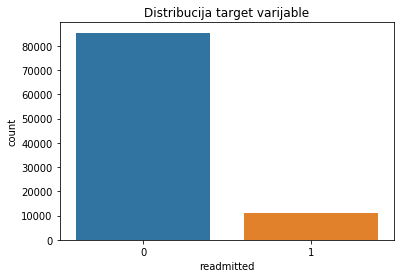

In [42]:
sns.countplot(df['readmitted']).set_title('Distribucija target varijable')

Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

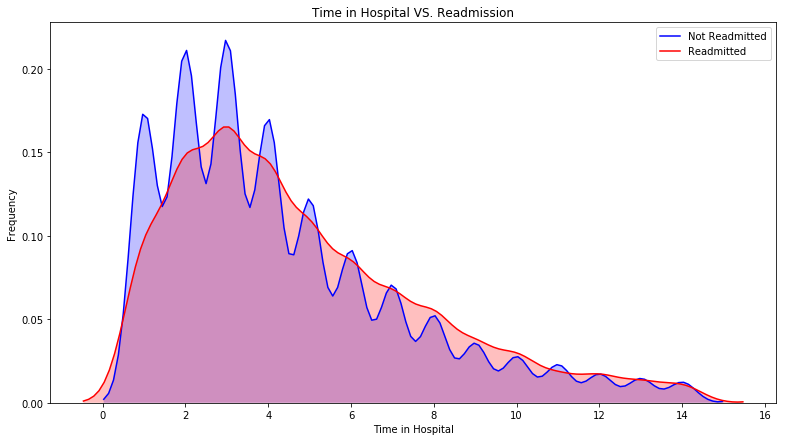

In [43]:
fig = plt.figure(figsize=(13,7),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

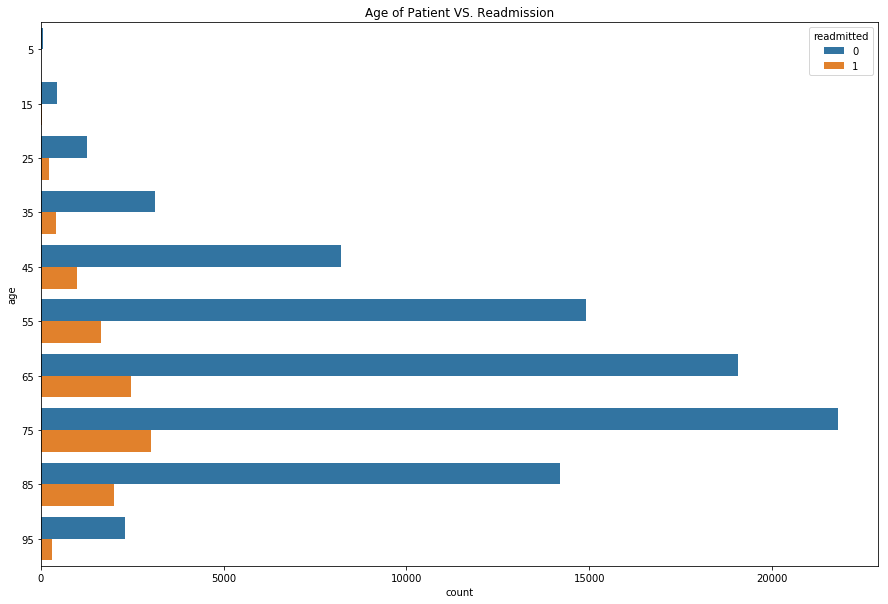

In [44]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y= df['age'], hue = df['readmitted']).set_title('Age of Patient VS. Readmission')

Text(0.5, 1.0, 'Number of medication used VS. Readmission')

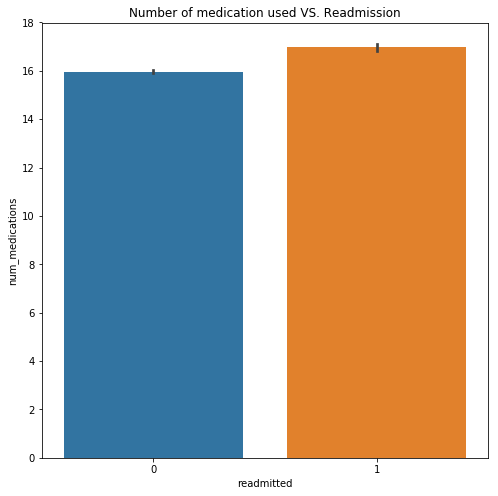

In [45]:
fig = plt.figure(figsize=(8,8))
sns.barplot(x = df['readmitted'], y = df['num_medications']).set_title("Number of medication used VS. Readmission")

Text(0.5, 1.0, 'Change of Medication VS. Readmission')

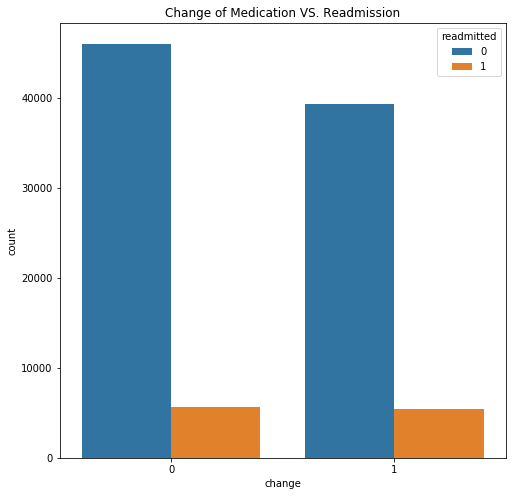

In [46]:
fig = plt.figure(figsize=(8,8))
sns.countplot(df['change'], hue = df['readmitted']).set_title('Change of Medication VS. Readmission')

Text(0.5, 1.0, 'Diabetes Medication prescribed VS Readmission')

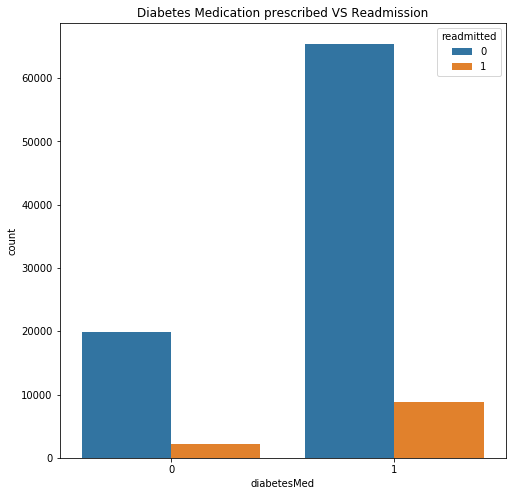

In [47]:
fig = plt.figure(figsize=(8,8))
sns.countplot(df['diabetesMed'], hue = df['readmitted']).set_title('Diabetes Medication prescribed VS Readmission')

Text(0.5, 1.0, 'Service Utilization VS. Readmission')

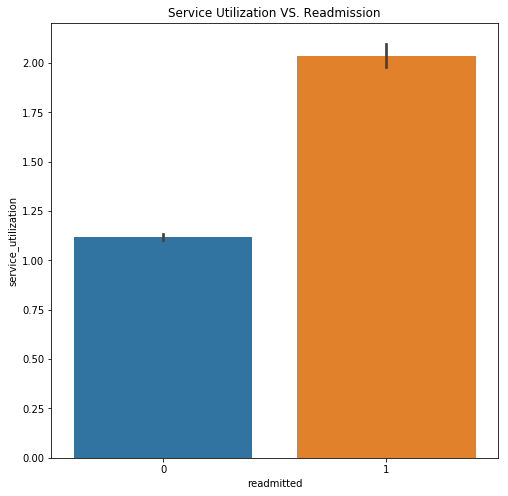

In [48]:
fig = plt.figure(figsize=(8,8))
sns.barplot( y = df['service_utilization'], x = df['readmitted']).set_title('Service Utilization VS. Readmission')

Text(0.5, 1.0, 'Number of lab procedure VS. Readmission')

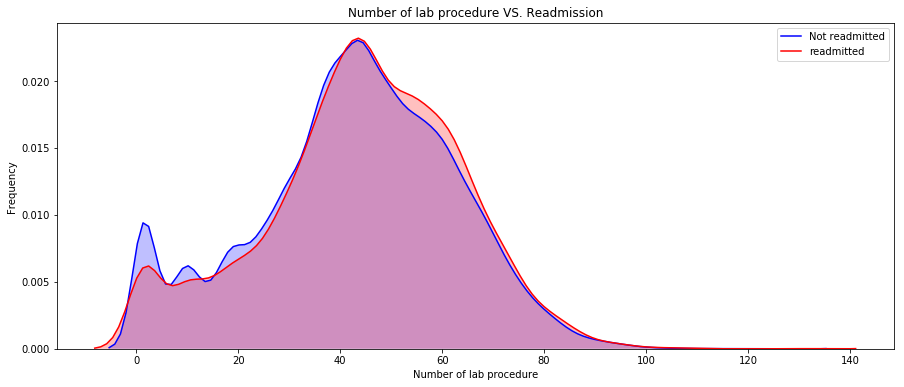

In [49]:
fig = plt.figure(figsize=(15,6),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')
ax.set(xlabel='Number of lab procedure', ylabel='Frequency')
plt.title('Number of lab procedure VS. Readmission')

## Skupovi za modelovanje

In [ ]:
df = pd.read_csv('first_processed.csv')

In [52]:
df.shape

(96446, 983)

In [50]:
out_of_model = ['encounter_id', 'patient_nbr','change','readmitted']

cols = [col for col in df.columns if col not in out_of_model]

In [51]:
X = df[cols]
y = df['readmitted']

y.value_counts()

0    85380
1    11066
Name: readmitted, dtype: int64

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

In [55]:
train = pd.concat([X_train, y_train], axis=1)

print(train.shape)
train.readmitted.value_counts()

(67512, 980)


0    59651
1     7861
Name: readmitted, dtype: int64

In [56]:
test = pd.concat([X_test, y_test], axis=1)

print(test.shape)
test['readmitted'].value_counts()

(28934, 980)


0    25729
1     3205
Name: readmitted, dtype: int64

In [57]:
test.to_csv(r'test.csv',index=False)
train.to_csv(r'train.csv',index=False)

## Balansiranje

oversampling

In [58]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print('Original dataset shape {}'.format(Counter(y_train)))

sm = SMOTE(random_state=2020)
train_input_new, train_output_new = sm.fit_sample(X_train, y_train)

train_input_new = pd.DataFrame(train_input_new, columns=X_train.columns)
train_output_new = pd.Series(train_output_new, name=y_train.name)

print('New dataset shape {}'.format(Counter(train_output_new)))

Using TensorFlow backend.


Original dataset shape Counter({0: 59651, 1: 7861})
New dataset shape Counter({0: 59651, 1: 59651})


In [59]:
train_b = pd.concat([train_input_new, train_output_new], axis=1)
print(train_b.shape)

train_b.to_csv(r'train_oversampled.csv', index=False)

(119302, 980)


In [60]:
train_b.readmitted.value_counts()

1    59651
0    59651
Name: readmitted, dtype: int64

undersampling

In [61]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

undersample = RandomUnderSampler(sampling_strategy='majority')

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

X_train_under = pd.DataFrame(X_train_under, columns=X_train.columns)
y_train_under = pd.Series(y_train_under, name=y_train.name)

# summarize class distribution
print(Counter(y_train_under))

Counter({0: 7861, 1: 7861})


In [62]:
train_under = pd.concat([X_train_under, y_train_under], axis=1)
print(train_under.shape)

train_under.to_csv(r'train_undersampled.csv', index=False)

(15722, 980)


In [63]:
train_under.readmitted.value_counts()

1    7861
0    7861
Name: readmitted, dtype: int64

## Normalizacija skupova podataka

In [64]:
from sklearn.preprocessing import StandardScaler

In [66]:
scaler = StandardScaler()

norm_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
norm_X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

norm_train = pd.concat([norm_X_train, y_train], axis=1)
norm_train.to_csv(r'norm_train.csv', index=False)

norm_test = pd.concat([norm_X_test, y_test], axis=1)
norm_test.to_csv(r'norm_test.csv', index=False)

## UZORKOVANJE

oversampled

In [67]:
train_over_80 = train_b.sample(frac=0.8, random_state=2020)

X_train_over_80 = train_over_80.drop('readmitted', axis=1)
y_train_over_80 = train_over_80['readmitted']
y_train_over_80.value_counts()

0    47779
1    47663
Name: readmitted, dtype: int64

In [68]:
train_over_60 = train_b.sample(frac=0.6, random_state=2020)

X_train_over_60 = train_over_60.drop('readmitted', axis=1)
y_train_over_60 = train_over_60['readmitted']
y_train_over_60.value_counts()

0    35873
1    35708
Name: readmitted, dtype: int64

In [69]:
train_over_40 = train_b.sample(frac=0.4, random_state=2020)

X_train_over_40 = train_over_40.drop('readmitted', axis=1)
y_train_over_40 = train_over_40['readmitted']
y_train_over_40.value_counts()

0    23923
1    23798
Name: readmitted, dtype: int64

In [70]:
train_over_20 = train_b.sample(frac=0.2, random_state=2020)

X_train_over_20 = train_over_20.drop('readmitted', axis=1)
y_train_over_20 = train_over_20['readmitted']
y_train_over_20.value_counts()

1    11938
0    11922
Name: readmitted, dtype: int64

In [71]:
train_over_80.to_csv(r'train_over_80.csv', index=False)
train_over_60.to_csv(r'train_over_60.csv', index=False)
train_over_40.to_csv(r'train_over_40.csv', index=False)
train_over_20.to_csv(r'train_over_20.csv', index=False)